# Fibonacci Bollinger Bands
> Can fibonacci numbers tell us anything about momentum?

- toc: false
- badges: false
- comments: true
- categories: [Blockchain]
- image: images/chart-preview.png

In [2]:
#hide
#@title 1. PRESS THE PLAY BUTTON ON THE LEFT (PACKAGES)
%%capture
import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go
import requests
import datetime

import numpy as np
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgb, to_rgba
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
import random
sns.set()
!pip install mplfinance
# More Plotting libaries 
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from dateutil.relativedelta import relativedelta

epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0
    
import time
!pip install yfinance
import yfinance as yf

In [3]:
#@title Data and Plot

def price_data(tick,p=140,d='Yahoo',t='1d'):
  """
  You can change these Intervals: 
  Currently set to
   - YAHOO: Interval is 1 day 
   - KUCOIN: Interval is 1 day
   - BINANCE: Interval is 1 hour 

  """

  if (d=='Yahoo'):
    ticker = yf.Ticker(tick)
    df = ticker.history(period=f'{p}d',interval='1d')
    cp = df.Close[len(df)-1]
  
  elif (d=='Kucoin'):
    link = f'https://openapi-v2.kucoin.com/api/v1/market/candles?type=1day&symbol={tick}'
    r = requests.get(link)	
    df = pd.DataFrame.from_records(r.json()['data'])
    df.columns = ['Time', 'Open', 'Close', 'High', 'Low', 'Volume', 'Turnover']
    df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')
    df = df.set_index('Time')
    df = df.head(p) 
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[0]

  elif (d=='Binance'): 
    url = 'https://api.binance.com/api/v3/klines'
    params = {
      'symbol': tick,
      'interval': t,
      'startTime' : round(unix_time_millis(datetime.datetime.now() - datetime.timedelta(minutes=p*24*60))) #200 hours ago
    }
    r = requests.get(url, params=params)
    results = r.json()
    df = pd.DataFrame.from_records(results)
    df.columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore.']
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', errors='coerce')
    df = df.set_index('Open time')
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[-1]
  elif (d=='Binance1h'): 
    url = 'https://api.binance.com/api/v3/klines'
    params = {
      'symbol': tick,
      'interval': '1h',
      'startTime' : round(unix_time_millis(datetime.datetime.now() - datetime.timedelta(minutes=4800))) #200 hours ago
    }
    r = requests.get(url, params=params)
    results = r.json()
    df = pd.DataFrame.from_records(results)
    df.columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore.']
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', errors='coerce')
    df = df.set_index('Open time')
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[-1]

  return df, cp


from numpy.core.fromnumeric import size
def fibonacci_bollinger_bands(df,cp,tick,t, n=20, m=3):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    ma = tp.rolling(n).mean()
    sd = m * tp.rolling(n).std()
    df['FBB_mid'] = ma
    df['FBB_up1'] = ma + (0.236 * sd)
    df['FBB_up2'] = ma + (0.382 * sd)
    df['FBB_up3'] = ma + (0.5 * sd)
    df['FBB_up4'] = ma + (0.618 * sd)
    df['FBB_up5'] = ma + (0.764 * sd)
    df['FBB_up6'] = ma + (1 * sd)
    df['FBB_low1'] = ma - (0.236 * sd)
    df['FBB_low2'] = ma - (0.382 * sd)
    df['FBB_low3'] = ma - (0.5 * sd)
    df['FBB_low4'] = ma - (0.618 * sd)
    df['FBB_low5'] = ma - (0.764 * sd)
    df['FBB_low6'] = ma - (1 * sd)

    if (cp > df['FBB_mid'][-1]):
      g = round(100*(cp - df['FBB_mid'][-1])/(df['FBB_up6'][-1]-df['FBB_mid'][-1]),2)
      print(f'The fibonacci bollinger shows {tick} is OVERBOUGHT by {g}% on a {t} scale')
    elif (cp < df['FBB_mid'][-1]):
      g = round(100*(df['FBB_mid'][-1]-cp)/(df['FBB_mid'][-1]-df['FBB_low6'][-1]),2)
      print(f'The fibonacci bollinger shows {tick} is OVERSOLD by {g}% on a {t} scale')


    return df


def fibonacci_plot(data1d, data1h, data15m, tick):

  data1d = data1d.tail(140)
  data1h = data1h.tail(140)
  data15m = data15m.tail(140)

  sns.set_style("whitegrid")
  f, (ax1, ax2, ax3 )  = plt.subplots(1, 3,figsize=(20,5), dpi= 150, 
                               facecolor='w', edgecolor='k')

  n = 3
  mpl.rcParams['axes.prop_cycle'] = plt.cycler("color", sns.color_palette("Set2"))

  FBB = ['FBB_up1','FBB_up2', 'FBB_up3', 'FBB_up4', 'FBB_up5', 'FBB_up6', 'FBB_low1',
       'FBB_low2', 'FBB_low3', 'FBB_low4', 'FBB_low5','FBB_low6']
  dfs = [data1d, data1h, data15m]
  periods = ['1d', '1h', '15m']
  widths = [0.8,0.02, 0.005]

  for ax,df,period,w in zip([ax1,ax2,ax3],dfs,periods,widths):

    i=0.1
    for col1,col2 in zip(FBB[0:6],FBB[6:12]):
      i = i+0.1
      ax.plot(df.index,df[col1],color='#ff6d00', alpha = i,zorder=1)
      ax.plot(df.index,df[col2],color='#240046', alpha = i,zorder=1)
    ax.plot(df.index,df['FBB_mid'],color='black', alpha = 1,zorder=1)

    ohlc = []
    for date, row in df.iterrows():
      openp, highp, lowp, closep = row[:4]
      ohlc.append([date2num(date), openp, highp, lowp, closep])

    candlestick_ohlc(ax, ohlc, colorup="#00f5d4", colordown="#ef233c", width=w, alpha=1.0)

    for txt in FBB:
      ax.annotate(round(df[txt][-1],2), (df.index[-1], df[txt][-1]),size=5)
    ax.annotate(round(df['FBB_mid'][-1],2), (df.index[-1], df['FBB_mid'][-1]),size=5)

    # Set Y axis format 
    ax.set_title(f'{tick} : Fibonacci Bollinger Bands {period}')
    ax.set_ylabel(f'$')
    ax1.set_xlabel('Time: Month-Year')
    ax2.set_xlabel('Time: Day-Month')
    ax3.set_xlabel('Time: Day-Hour')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))

  # ax1.set_yscale('log')
  plt.grid(True, which="both", ls="-", alpha = 0.3)
  plt.show()


{% include alert.html text="Roses are red, violets are blue. This is not financial advice, I genuinely have no clue." %}

### Fibbonacci bollinger bands

The bands aim to show if the asset is overbought or oversold within a given timeframe. In combination with other indicators can be useful in determining a price entry for a given asset. 


<IPython.core.display.Javascript object>

The fibonacci bollinger shows BTCUSDT is OVERBOUGHT by 15.64% on a 1d scale
The fibonacci bollinger shows BTCUSDT is OVERBOUGHT by 57.23% on a 1h scale
The fibonacci bollinger shows BTCUSDT is OVERBOUGHT by 19.58% on a 15m scale


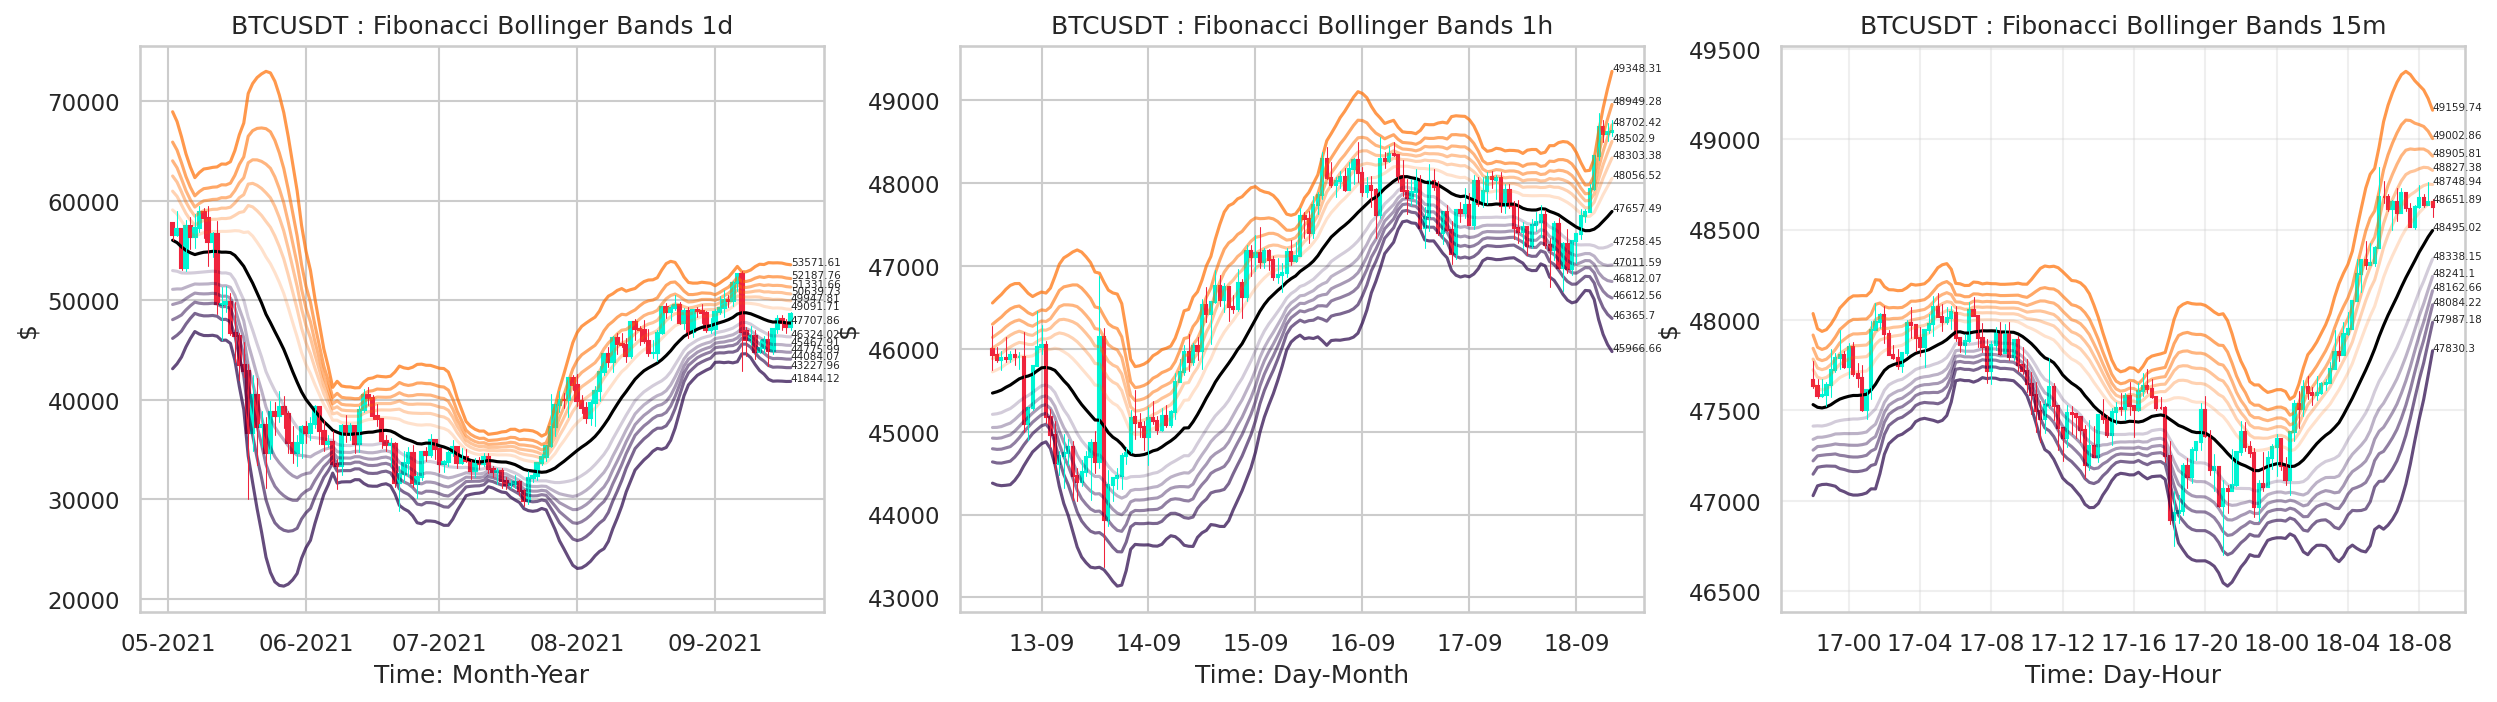

The fibonacci bollinger shows ETHUSDT is OVERSOLD by 2.82% on a 1d scale
The fibonacci bollinger shows ETHUSDT is OVERBOUGHT by 56.83% on a 1h scale
The fibonacci bollinger shows ETHUSDT is OVERBOUGHT by 36.49% on a 15m scale


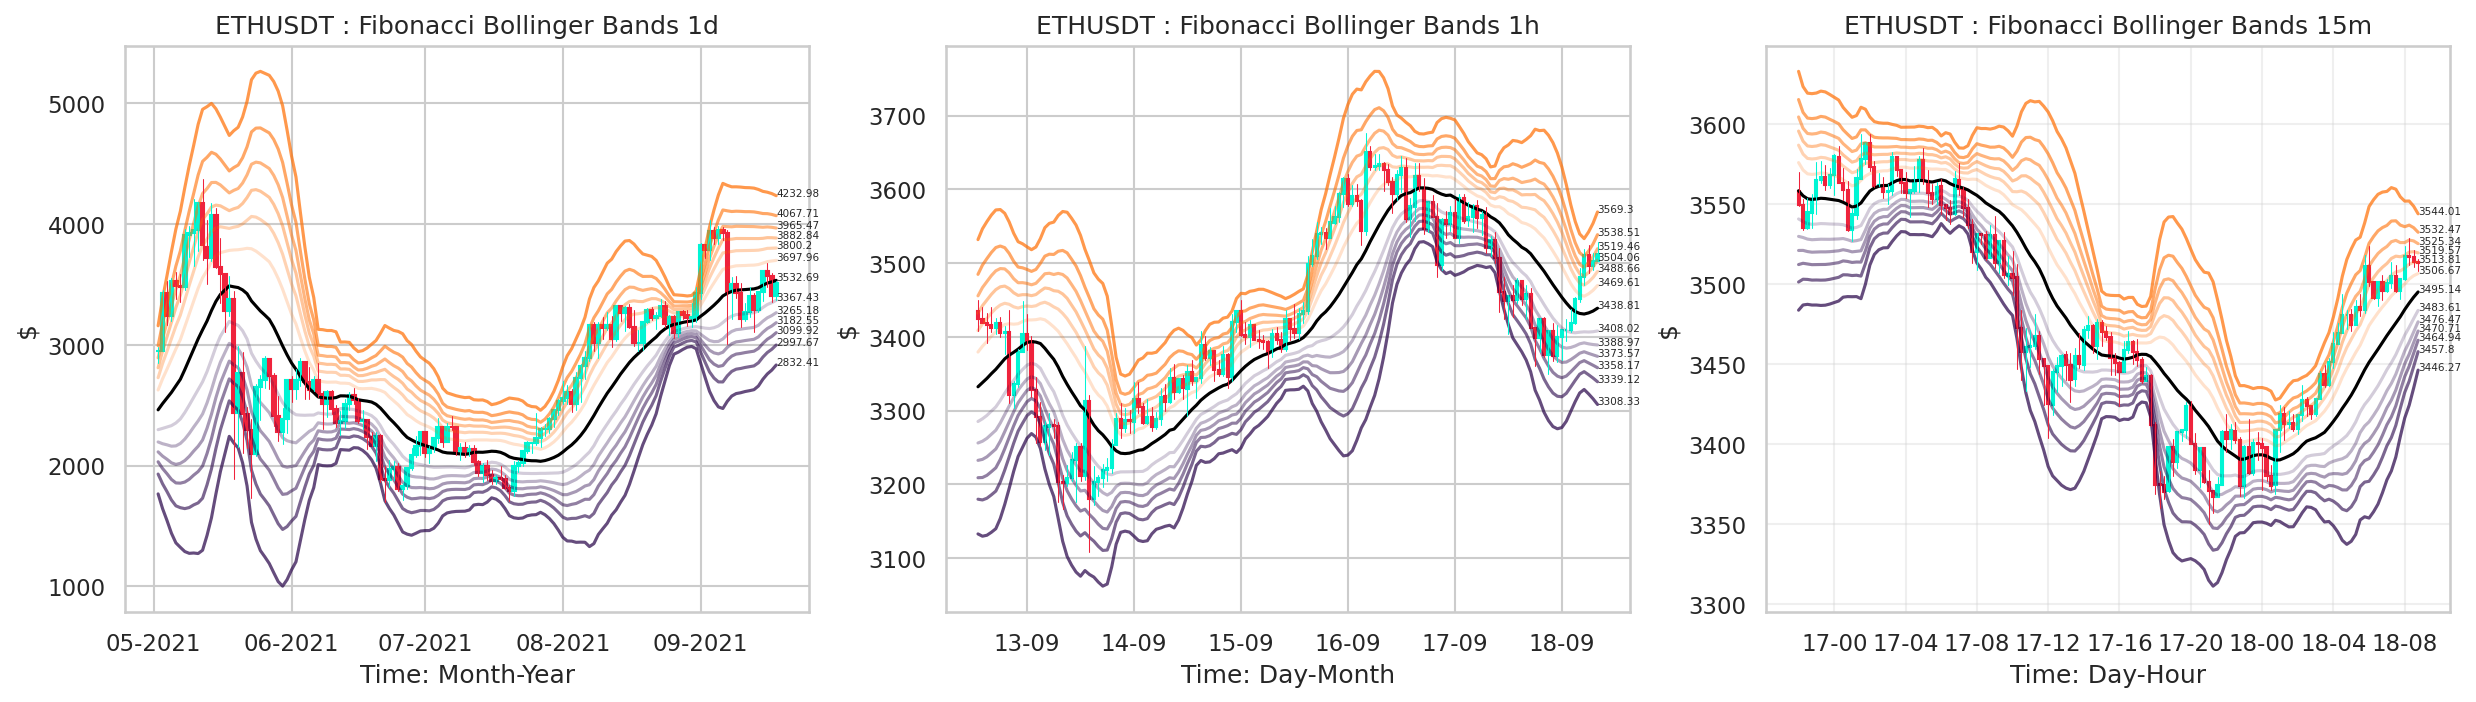

The fibonacci bollinger shows SOLUSDT is OVERBOUGHT by 9.06% on a 1d scale
The fibonacci bollinger shows SOLUSDT is OVERBOUGHT by 86.21% on a 1h scale
The fibonacci bollinger shows SOLUSDT is OVERBOUGHT by 40.45% on a 15m scale


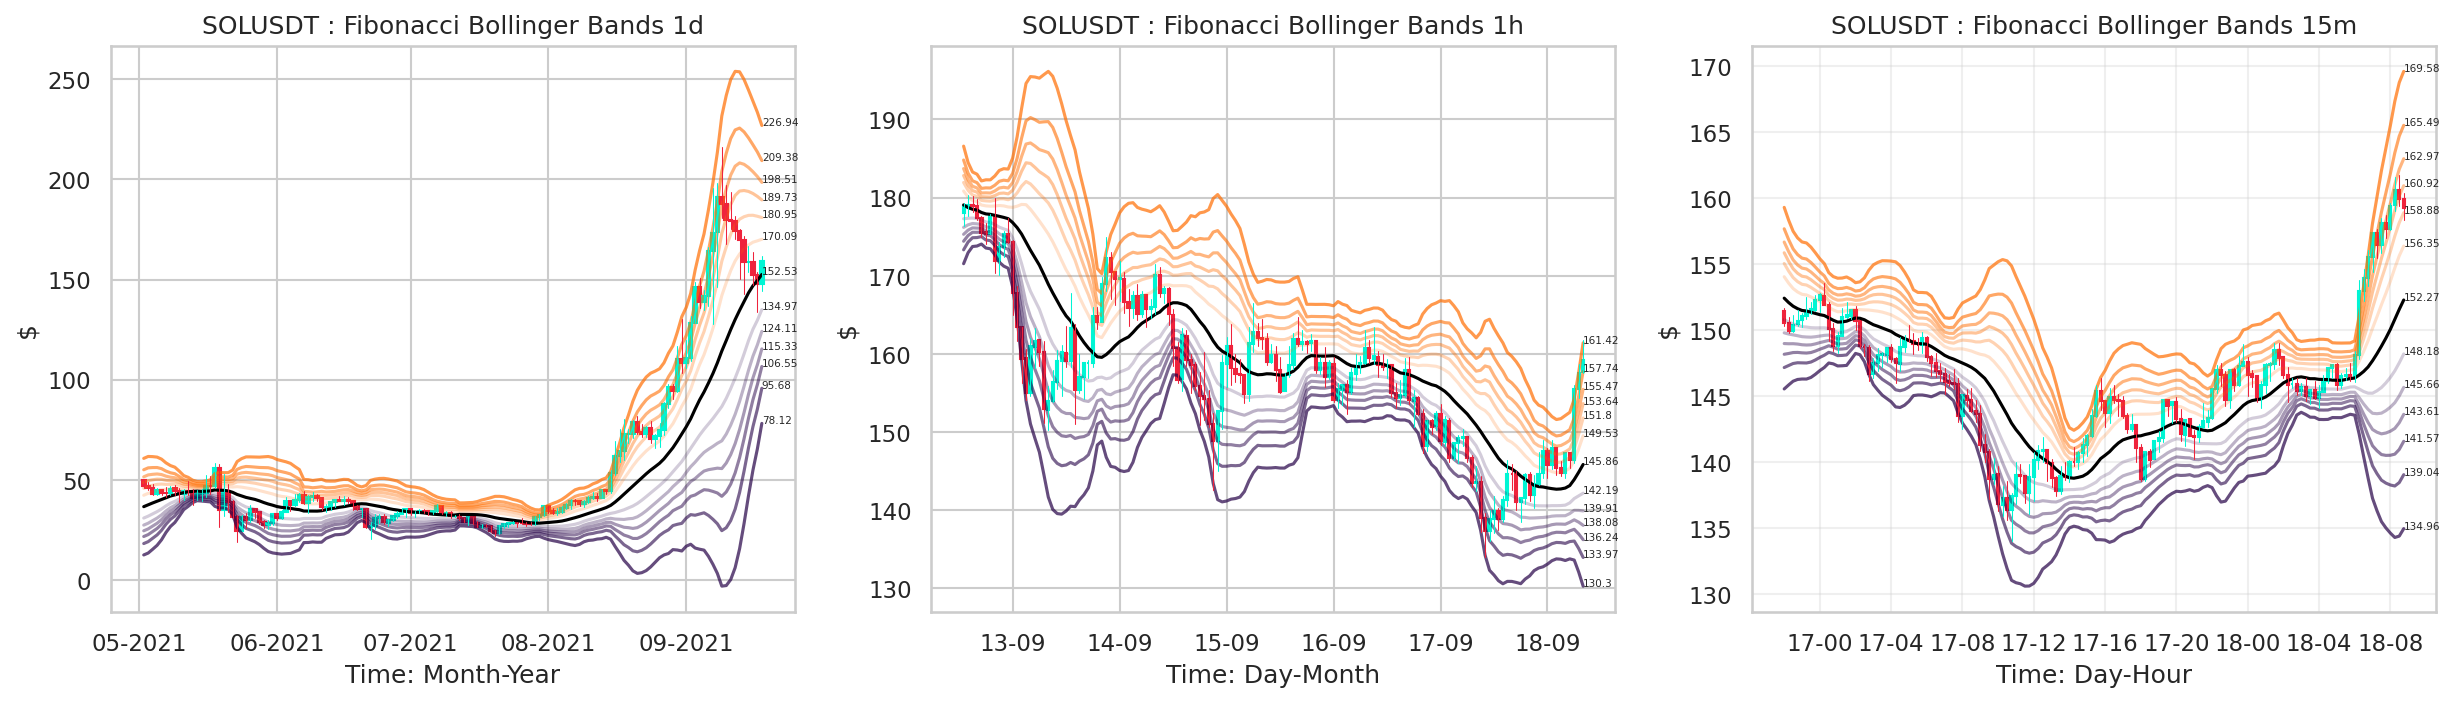

In [5]:
#hide_input
# _notebooks/2021-08-17-Fibonacci-Bollinger-Bands.ipynb
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
pd.options.mode.chained_assignment = None

for tick in ['BTCUSDT','ETHUSDT','SOLUSDT']:
  #Fibb Bands
  data1d, cp = price_data(tick,500, d='Binance',t='1d')
  data1h, cp = price_data(tick,p=20,d='Binance',t='1h')
  data15m, cp = price_data(tick,p=5,d='Binance',t='15m')
  data1d = fibonacci_bollinger_bands(data1d,cp,tick,t='1d')
  data1h = fibonacci_bollinger_bands(data1h,cp,tick,t='1h')
  data15m = fibonacci_bollinger_bands(data15m,cp,tick,t='15m')
  fibonacci_plot(data1d, data1h, data15m, tick)